In [1]:
import sys
sys.path.append('/Users/jinchen/Desktop/DSE/IntroML/Project/project-product-price-prediction')

In [2]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
matplotlib.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['figure.constrained_layout.use'] = True

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from final.feature_extraction.clean_text import *
from final.feature_encoding.one_hot_encoding import one_hot_encode_feature
from final.feature_extraction.extract_text_info import extract_general_row_info, extract_row_word_counts
from final.model_evaluation.classification_model_evaluation import train_classification_model
from final.model_evaluation.visualizations import visualize_model_feature_importances, visualize_2d_cluster_with_legend


In [3]:
df = pd.read_csv("../../data/random_samples/stratified_sampling_data_by_c1_sz50000_1619216598.csv")
df.shape

(50000, 10)

# Encode C1

In [4]:
encode_df, encode_col = one_hot_encode_feature(df, encode_column='c1',drop_first=False)
encode_df.shape

(50000, 18)

In [6]:
encode_df.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,c2,c3,c1_beauty,c1_electronics,c1_home,c1_kids,c1_men,c1_other,c1_sports & outdoors,c1_vintage & collectibles,c1_women
0,1341364,Toddler Jordans size 11c,2,Nike,35.0,1,Boy's Jordan's size 11c. Like new condition. U...,boys 2t-5t,shoes,0,0,0,1,0,0,0,0,0
1,1311357,Urban Decay Naked 2 Eyeshadow Palette,2,Urban Decay,29.0,0,"swatched, authentic, and in good condition. Ma...",makeup,makeup palettes,1,0,0,0,0,0,0,0,0
2,28470,Bath & Body Works Scentportable,3,Bath & Body Works,5.0,1,Skull with Bow,home décor,home fragrance,0,0,1,0,0,0,0,0,0
3,208231,Pokémon Snap N64,4,Nintendo,12.0,0,Tested and cleaned. Guaranteed to work like ne...,video games & consoles,games,0,1,0,0,0,0,0,0,0
4,81684,NWT Sexy Valentine's Day Dress Rue21 XL,1,rue,8.0,1,New ladies Rue21 Cocktail/Party dress. Size XL...,dresses,"above knee, mini",0,0,0,0,0,0,0,0,1


In [7]:
encode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   train_id                   50000 non-null  int64  
 1   name                       50000 non-null  object 
 2   item_condition_id          50000 non-null  int64  
 3   brand_name                 50000 non-null  object 
 4   price                      50000 non-null  float64
 5   shipping                   50000 non-null  int64  
 6   item_description           50000 non-null  object 
 7   c2                         50000 non-null  object 
 8   c3                         50000 non-null  object 
 9   c1_beauty                  50000 non-null  uint8  
 10  c1_electronics             50000 non-null  uint8  
 11  c1_home                    50000 non-null  uint8  
 12  c1_kids                    50000 non-null  uint8  
 13  c1_men                     50000 non-null  uin

# Extract Item Name Features

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
num_of_processes  = 8
col_name = 'name'
clean_col_name = "clean_%s" % col_name

df = parallelize(encode_df, partial(extract_counts, col_name=col_name, prefix="bef"), num_of_processes)
df = parallelize(encode_df, partial(extract_info, col_name=col_name, stop_words=stop_words), num_of_processes)

progress-bar: 100%|██████████| 6250/6250 [01:05<00:00, 94.89it/s] 


# Split Train Test

In [8]:
X = df.select_dtypes(include=['int64']).drop(columns=list(encode_col)+['train_id'])
x_col = X.columns
X['name'] = df['name']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item_condition_id  50000 non-null  int64 
 1   shipping           50000 non-null  int64 
 2   upper_word_count   50000 non-null  int64 
 3   upper_char_count   50000 non-null  int64 
 4   stopword_count     50000 non-null  int64 
 5   punctuation_count  50000 non-null  int64 
 6   number_count       50000 non-null  int64 
 7   name               50000 non-null  object
dtypes: int64(7), object(1)
memory usage: 3.1+ MB


In [9]:
y = encode_df[encode_col]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   c1_beauty                  50000 non-null  uint8
 1   c1_electronics             50000 non-null  uint8
 2   c1_home                    50000 non-null  uint8
 3   c1_kids                    50000 non-null  uint8
 4   c1_men                     50000 non-null  uint8
 5   c1_other                   50000 non-null  uint8
 6   c1_sports & outdoors       50000 non-null  uint8
 7   c1_vintage & collectibles  50000 non-null  uint8
 8   c1_women                   50000 non-null  uint8
dtypes: uint8(9)
memory usage: 439.6 KB


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, 
                                                    test_size=0.30, random_state=42, stratify = y)

# Vectorization of Item Name

In [11]:
num_features = 20
tv = TfidfVectorizer(max_features=num_features)
train_name_feature = tv.fit_transform(X_train.name.to_list())

train_name_feature.toarray().shape

(35000, 20)

In [12]:
X_train = np.concatenate((train_name_feature.toarray(), X_train[x_col].values),axis=1)
X_test = np.concatenate((tv.transform(X_test.name.to_list()).toarray(), X_test[x_col].values),axis=1)

In [13]:
names = tv.get_feature_names()
names

['and',
 'black',
 'bundle',
 'dunn',
 'fitbit',
 'for',
 'free',
 'funko',
 'iphone',
 'men',
 'new',
 'nike',
 'of',
 'pink',
 'pop',
 'rae',
 'set',
 'shirt',
 'size',
 'under']

In [14]:
x_tf_names = ['tf%02d_%s'%(i,names[i-1]) for i in range(1, num_features+1)]
x_tf_names += list(x_col)

# Classification - Random Forest

In [15]:
rf_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(RandomForestClassifier(n_estimators=50), 
                                                              X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.5537714285714286

[[2212  129   98  160   45  591   36  289  329]
 [ 255 2358   52  191   64  206   33  371  359]
 [ 375   91 2276  141   45  464   27  152  318]
 [ 342  242   77 1694  138  303  119  449  525]
 [ 172  214   44  205 2094  191  213  263  493]
 [ 610  143  111  146   50 2324   19  194  292]
 [ 178  178   50  231  179  223 2243  226  380]
 [ 366  305   72  247   78  262   39 2075  445]
 [ 302  226   68  276  150  251  139  371 2106]]
Train accuracy for each class
c1_kids              - 0.43559
c1_vintage & collectibles - 0.53356
c1_men               - 0.53844
c1_women             - 0.54153
c1_beauty            - 0.56878
c1_sports & outdoors - 0.57690
c1_home              - 0.58524
c1_other             - 0.59758
c1_electronics       - 0.60633
--------------------------------------------------
--------------------------------------------------
Test Accuracy: 0.36946666666666667

[[615 120  93 114  42 314  24 171 174]
 [152 738  35 109  55 125  31 234 187]
 

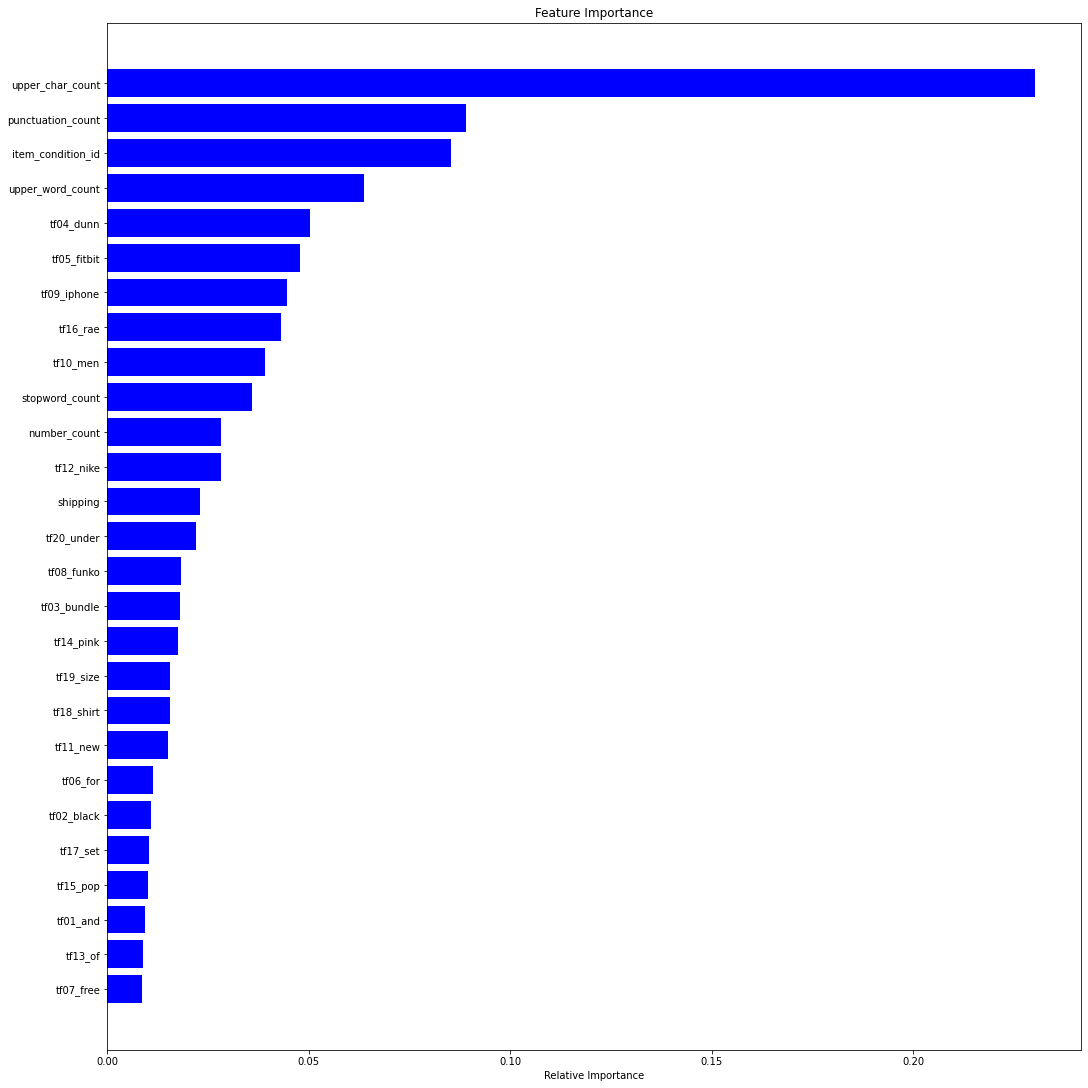

In [16]:
feature_importances = visualize_model_feature_importances(rf_model, x_tf_names, title = "Feature Importance")

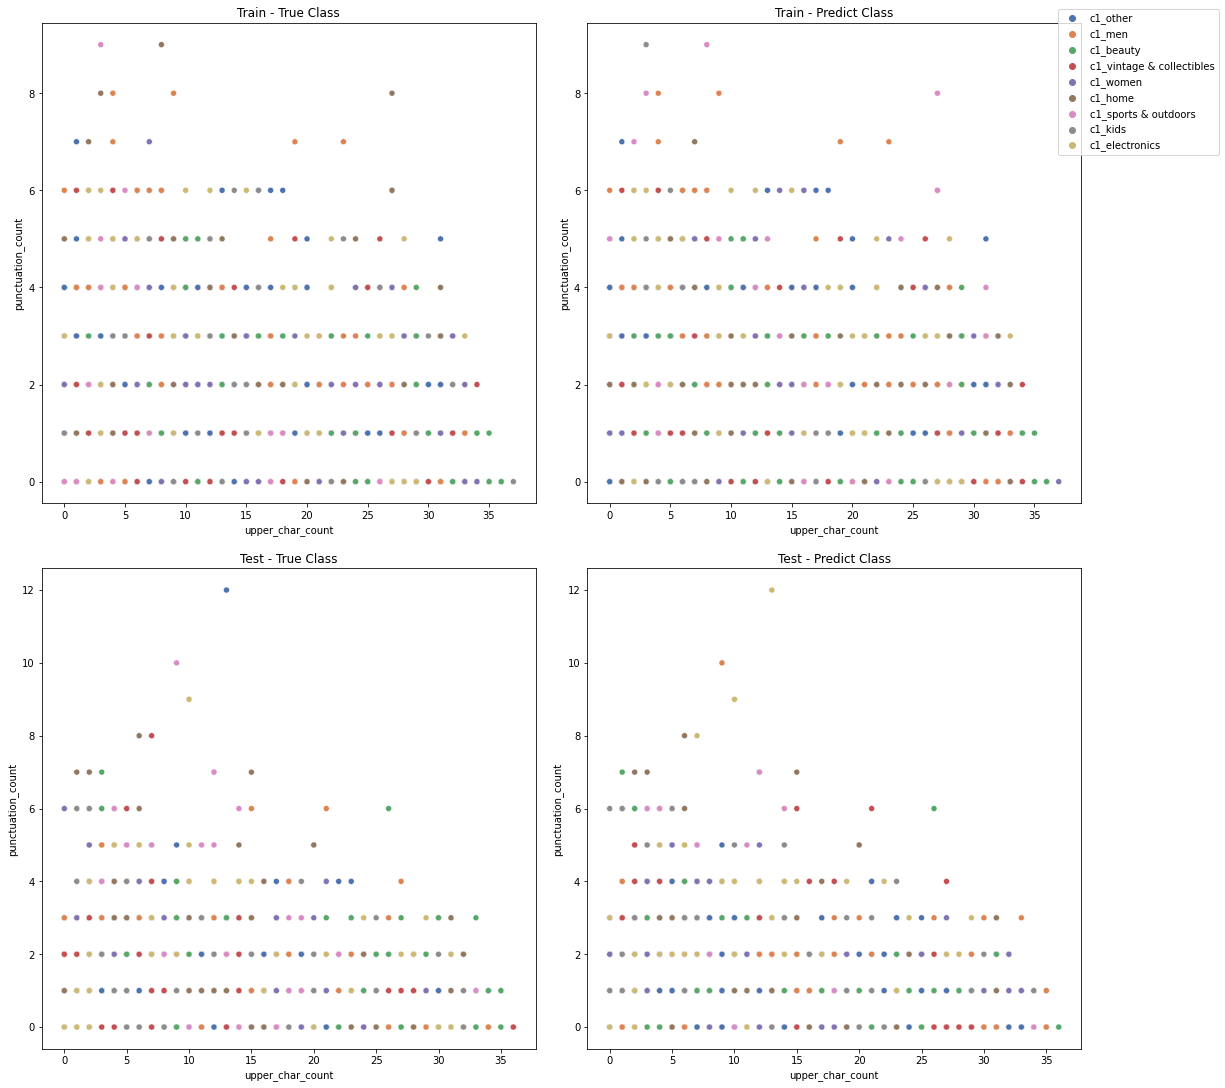

In [17]:
visualize_2d_cluster_with_legend('c1', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred)

# Classification - Logistic Regression

In [18]:
lr_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(LogisticRegression(max_iter=500), 
                                                             X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.3852285714285714

[[1605  171  124  117   11 1002    0  366  493]
 [ 382 1697   60  111   18  448    0  543  630]
 [ 503  102 1775  127   13  773    0  164  432]
 [ 442  369   99  527  138  561  214  731  808]
 [ 223  316   51  237 1233  339  412  304  774]
 [ 869  169  130   63   67 1964    2  190  435]
 [ 195  233   54  186  209  372 1708  260  671]
 [ 488  551   82  199   17  467    5 1422  658]
 [ 467  241   77  318  143  473  192  426 1552]]
Train accuracy for each class
c1_kids              - 0.13551
c1_men               - 0.31705
c1_vintage & collectibles - 0.36565
c1_women             - 0.39907
c1_beauty            - 0.41270
c1_electronics       - 0.43636
c1_sports & outdoors - 0.43930
c1_home              - 0.45642
c1_other             - 0.50501
--------------------------------------------------
--------------------------------------------------
Test Accuracy: 0.3821333333333333

[[685  86  52  56   2 439   2 169 176]
 [155 718  31  60  10 186   0 239 267]
 [

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


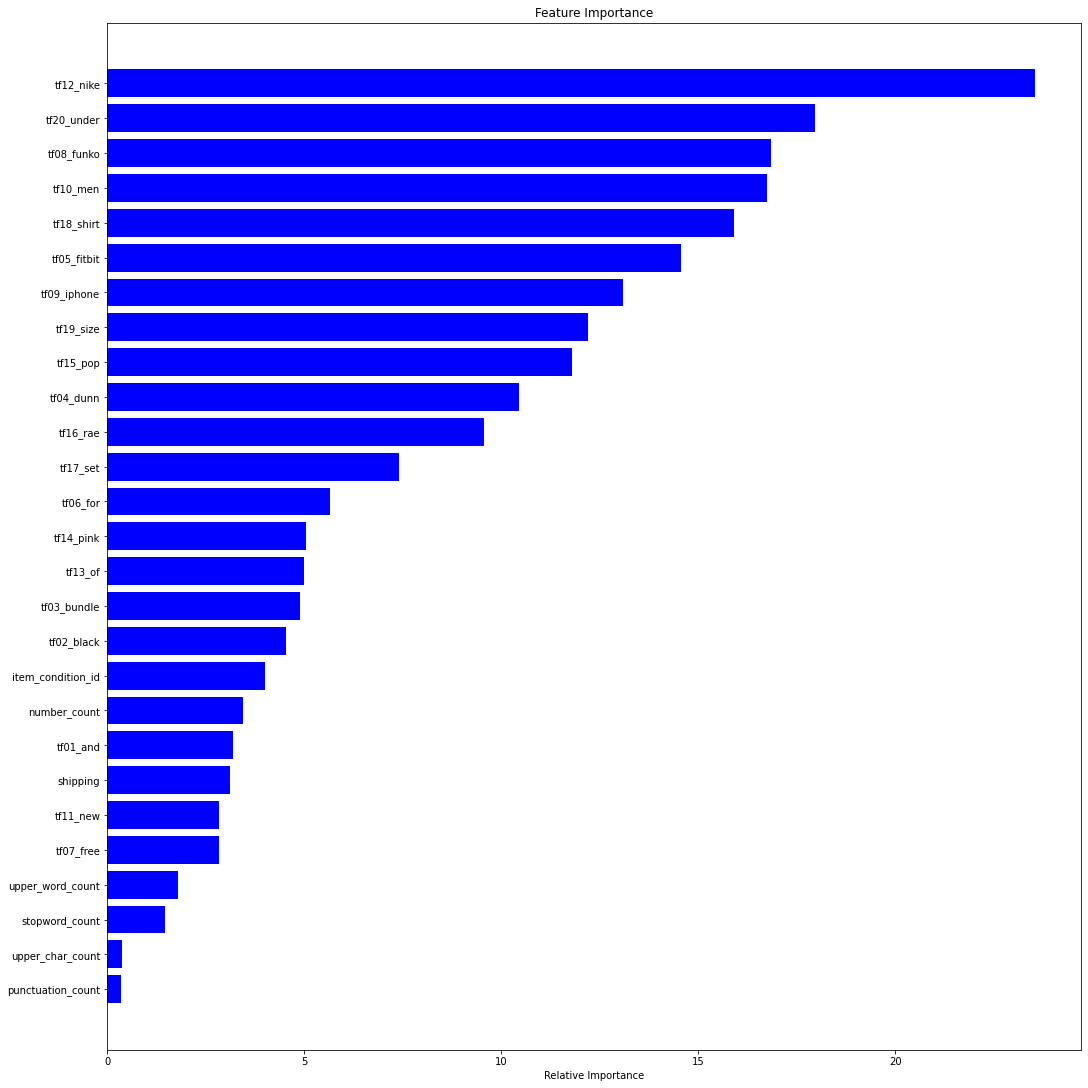

In [19]:
feature_importances = visualize_model_feature_importances(lr_model, x_tf_names, title = "Feature Importance")

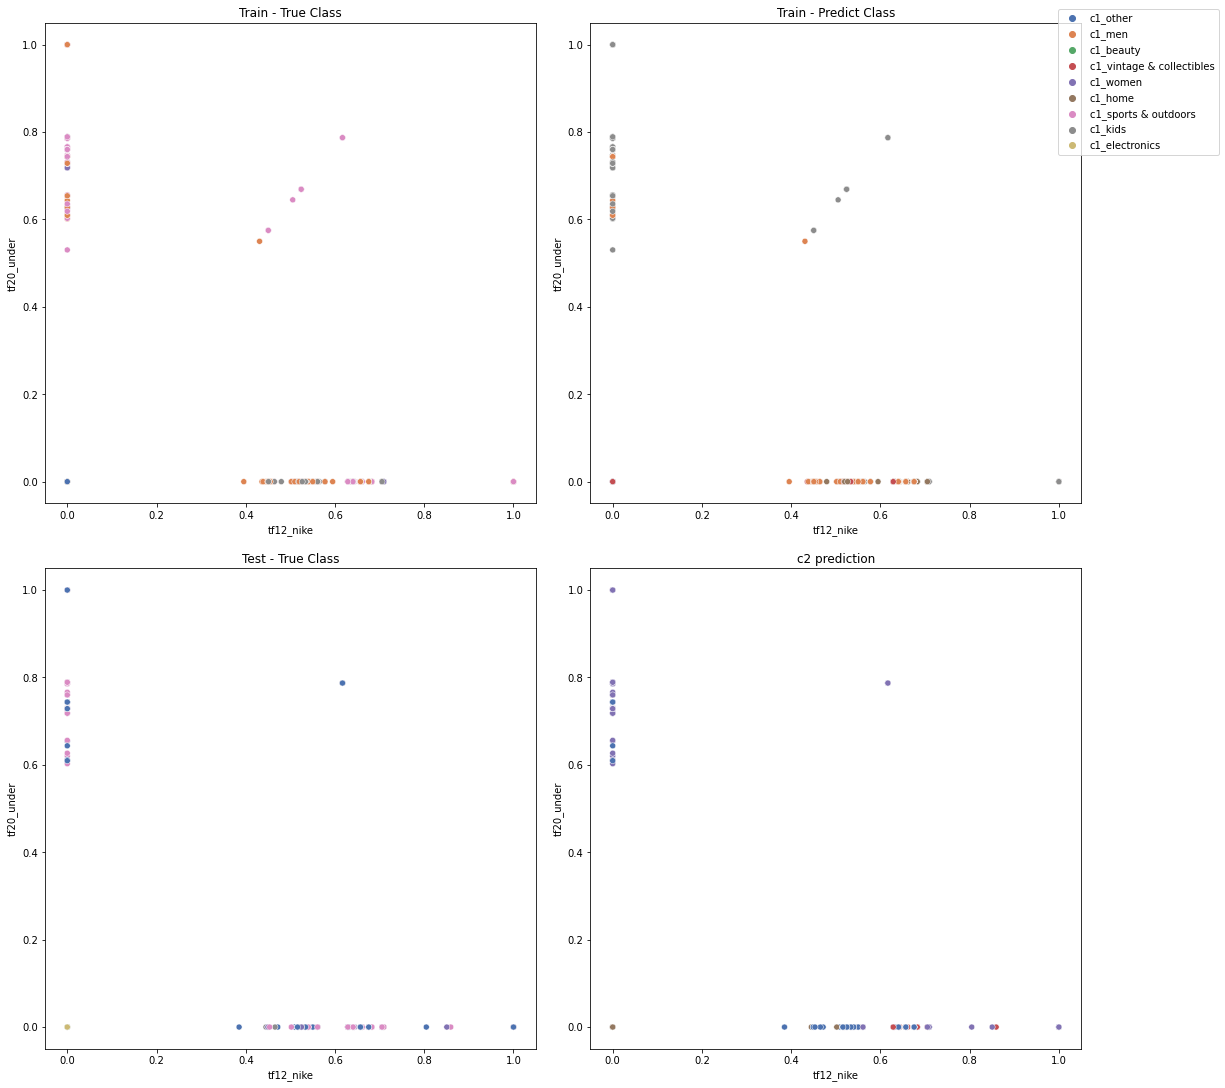

In [20]:
visualize_2d_cluster_with_legend('c1', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred,
                                legend = True, title = "c1 prediction")